In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Load data
df = pd.read_csv('mumbai-house-price-data-cleaned.csv')

# Handle outliers (cap price and area at 95th percentile)
price_cap = df['price'].quantile(0.95)
area_cap = df['area'].quantile(0.95)
df = df[(df['price'] <= price_cap) & (df['area'] <= area_cap)]

# Log-transform price to reduce skewness
df['price'] = np.log1p(df['price'])

# Select features and target
numeric_features = ['area', 'bedroom_num', 'bathroom_num', 'balcony_num', 'age', 'total_floors']
categorical_features = ['locality', 'furnished']
X = df[numeric_features + categorical_features]
y = df['price']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline([
            ('scaler', StandardScaler()),
            ('poly', PolynomialFeatures(degree=2, include_bias=False))
        ]), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=True), categorical_features)
    ])

# Create pipeline with Ridge regression
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', Ridge(alpha=10.0))  # Increased alpha for stronger regularization
])

# Train model
pipeline.fit(X_train, y_train)

# Predict and evaluate
y_pred = pipeline.predict(X_test)
y_pred_exp = np.expm1(y_pred)  # Inverse log-transform for interpretation
y_test_exp = np.expm1(y_test)

# Metrics
rmse = np.sqrt(mean_squared_error(y_test_exp, y_pred_exp))
mae = mean_absolute_error(y_test_exp, y_pred_exp)
r2 = r2_score(y_test_exp, y_pred_exp)
print(f'RMSE: {rmse:.2f}')
print(f'MAE: {mae:.2f}')
print(f'R2 Score: {r2:.2f}')

# Cross-validation
cv_scores = cross_val_score(pipeline, X, y, cv=5, scoring='r2')
print(f'Cross-validated R2: {cv_scores.mean():.2f} (+/- {cv_scores.std() * 2:.2f})')

RMSE: 4587168.58
MAE: 2828641.59
R2 Score: 0.81
Cross-validated R2: 0.85 (+/- 0.01)


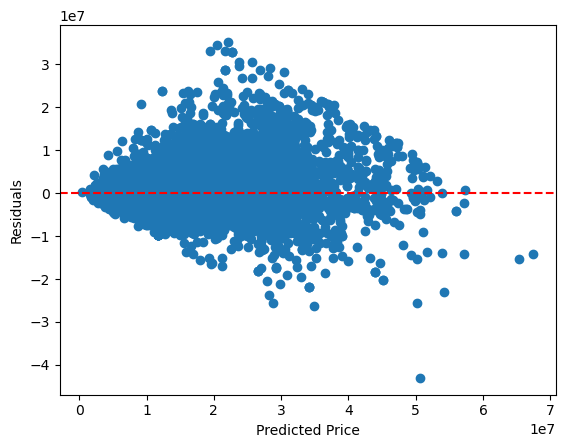

In [4]:
import matplotlib.pyplot as plt
residuals = y_test_exp - y_pred_exp
plt.scatter(y_pred_exp, residuals)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Predicted Price')
plt.ylabel('Residuals')
plt.show()

In [5]:
def predict_house_price(pipeline):
    area = float(input("Enter area (sq.ft.): "))
    bedroom_num = int(input("Enter number of bedrooms: "))
    bathroom_num = int(input("Enter number of bathrooms: "))
    balcony_num = int(input("Enter number of balconies: "))
    age = int(input("Enter age of property (years): "))
    total_floors = int(input("Enter total floors in building: "))
    locality = input("Enter locality (e.g., Bandra): ")
    furnished = input("Enter furnishing status (Unfurnished/Semi-Furnished/Furnished): ")

    input_data = pd.DataFrame({
        'area': [area],
        'bedroom_num': [bedroom_num],
        'bathroom_num': [bathroom_num],
        'balcony_num': [balcony_num],
        'age': [age],
        'total_floors': [total_floors],
        'locality': [locality],
        'furnished': [furnished]
    })

    predicted_log_price = pipeline.predict(input_data)
    predicted_price = np.expm1(predicted_log_price)[0]
    print(f"Predicted price: ₹{predicted_price:,.2f}")

predict_house_price(pipeline)

ValueError: could not convert string to float: ''